# Kanto Net (Gen 1 Pokemon Classifier) 

Problem: Using a image dataset from Kaggle, build a multiclass image classifer using PyTorch and the VGG16 model architype.


In [ ]:
# mount to drive if you want to save the model data to dive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## IMPORTING POKEMON IMAGE DATA FROM KAGGLE
Most comprehensive dataset: https://www.kaggle.com/datasets/bhawks/pokemon-generation-one-22k


Alternatives:
* https://www.kaggle.com/datasets/thedagger/pokemon-generation-one
* https://www.kaggle.com/datasets/mikoajkolman/pokemon-images-first-generation17000-files
* https://www.kaggle.com/datasets/unexpectedscepticism/11945-pokemon-from-first-gen

In [ ]:
# upload the kaggle.json API token from kaggle account page. 
# kaggle -> account settings -> API -> expired token -> create token

from google.colab import files
files.upload()

In [ ]:
# install kaggle, quiet mode

! pip install -q kaggle

In [ ]:
# in order: fresh runtime -> upload kaggle.json -> install kaggle -> run this cell
# working if you see a head of kaggle dataset.

! mkdir ~/.kaggle
! mv ./kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list

ref                                                        title                                        size  lastUpdated          downloadCount  voteCount  usabilityRating  
---------------------------------------------------------  ------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
themrityunjaypathak/covid-cases-and-deaths-worldwide       Covid Cases and Deaths WorldWide              8KB  2023-02-01 12:22:51           8904        287  1.0              
datascientistanna/customers-dataset                        Shop Customer Data                           23KB  2023-02-07 18:42:21           7361        173  1.0              
amaanansari09/top-100-songs                                Top 100 songs                                 6KB  2023-02-16 18:55:35           2221         72  1.0              
justin2028/unemployment-in-america-per-us-state            Unemployment in America, Per US State       826KB  2023-03-02 07:2

In [ ]:
# Download & unzip dataset from kaggle to /content/sample_data/ directory

! kaggle datasets download -d bhawks/pokemon-generation-one-22k -p /content/sample_data/ --unzip

100% 1.95G/1.95G [01:27<00:00, 23.3MB/s]
100% 1.95G/1.95G [01:27<00:00, 24.0MB/s]


In [ ]:
# Remove all images that are not '.jpg' / '.png' / '.jpeg'
# REASON: These are insignificant to the overall data set and might cause issues passed through model

import os
import glob

total_files = glob.glob('/content/sample_data/PokemonData/*/*')
jpg_list = glob.glob('/content/sample_data/PokemonData/*/*.jpg')
png_list = glob.glob('/content/sample_data/PokemonData/*/*.png')
jpeg_list = glob.glob('/content/sample_data/PokemonData/*/*.jpeg')


need_to_remove = [ i for i in total_files if i not in jpg_list + png_list + jpeg_list ]
num_removed = 0

for filePath in need_to_remove:
  try:
      os.remove(filePath)
      num_removed+=1
  except:
      print(f'Error while removing file: {filePath}')

print(f'\nDONE! Removed {num_removed} files.')


DONE! Removed 37 files.


In [ ]:
# Validate all files are '.jpg' / '.png' / 'jpeg'

import os
from os.path import splitext

root_dir = '/content/sample_data/PokemonData'

ext_set=set()
for pk in os.listdir(root_dir):
  dir = os.path.join(root_dir, pk)

  for img in os.listdir(dir):
    filename, ext = splitext(img)
    
    if ext not in ext_set:
      ext_set.add(ext)
  

result = "PASSED" if len(ext_set) == 3 else 'FAILED'
print(f'Extension Test: {result}')

Extension Test: PASSED


In [ ]:
import os
from pathlib import Path

# root directory of the images
root_path = Path('/content/sample_data/PokemonData')

# all each directory in root_path
dirs = os.listdir(root_path)

# construct pokedex which is the pokemon name with the number of images
pokedex = {}
for pokemon in dirs:
    pokedex[pokemon] = len(os.listdir(os.path.join(root_path, pokemon)))

# using this as the class list
pokemon_labels = list(pokedex.keys())

# log results
print(f'Total Number of Pokemon: {len(pokemon_labels)}')
print(f'Total Number of Images: {sum(list(pokedex.values()))}')

Total Number of Pokemon: 151
Total Number of Images: 22619


In [ ]:
# find pokemon with the most images
top10 = sorted(pokedex.items(), key = lambda x: x[1], reverse = True)[:10]

top10

[('Mewtwo', 408),
 ('Charmander', 407),
 ('Pikachu', 400),
 ('Squirtle', 339),
 ('Bulbasaur', 337),
 ('Psyduck', 283),
 ('Fearow', 202),
 ('Gyarados', 201),
 ('Gengar', 194),
 ('Rapidash', 187)]

In [ ]:
# PROBLEM: Need to undersample some top pokemon bc have too many images / not uniform distribution.
# SOLUTION: Cap top 8 pokemon to ~200 images? Use a small random number for randomness

import os
import glob
from random import sample

oversamples = [ i[0] for i in top10[:8] ]
img_cap = 200

for pk in oversamples:
  all_imgs = glob.glob(f'/content/sample_data/PokemonData/{pk}/*')
  num_to_remove = len(all_imgs) - img_cap + sample(range(-10,10), 1)[0] # random number for randomness

  try:
    for file in sample(all_imgs, num_to_remove):
      os.remove(file)
  except:
    print('Couldn\'t remove file.')

for pk in oversamples:
  all_imgs = glob.glob(f'/content/sample_data/PokemonData/{pk}/*')
  print(f'New Number of {pk} images: {len(all_imgs)}')

print('\nDONE!')

New Number of Mewtwo images: 205
New Number of Charmander images: 201
New Number of Pikachu images: 202
New Number of Squirtle images: 195
New Number of Bulbasaur images: 200
New Number of Psyduck images: 202
New Number of Fearow images: 195
New Number of Gyarados images: 194

DONE!


## Viewing the Data

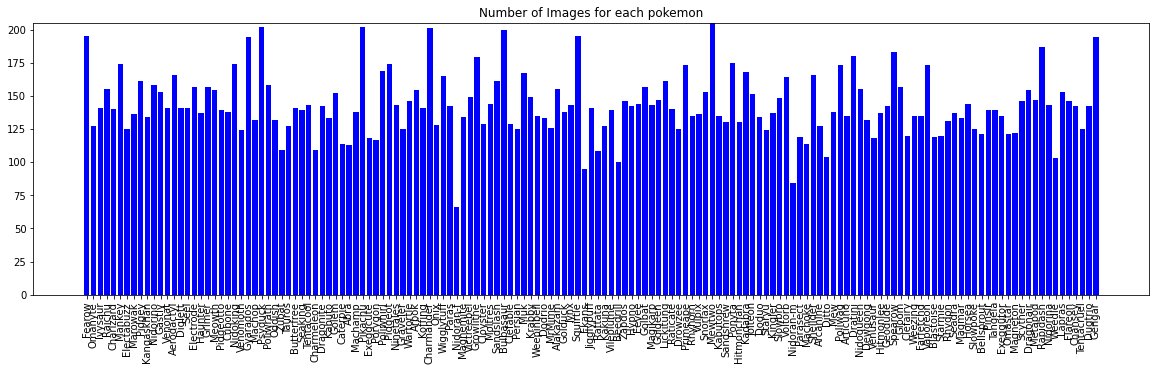

In [ ]:
# the distribution should be more 'uniform' now

import matplotlib.pyplot as plt
from pathlib import Path
import os

root_path = Path('/content/sample_data/PokemonData')
dirs = os.listdir(root_path)

# remake new pokedex after image purging
pokedex = {}
for pokemon in dirs:
    pokedex[pokemon] = len(os.listdir(os.path.join(root_path, pokemon)))

# this is used for the classifer layer when setting up model
pokemon_labels = list(pokedex.keys())

# bargraph of photo distribution
plt.figure(figsize=(20,5))
plt.title("Number of Images for each pokemon")
plt.bar(pokemon_labels, list(pokedex.values()), color='blue')
plt.margins(y=0)
plt.xticks(rotation=90)
plt.show()

## PREPARING THE DATA

In [ ]:
# split folders into training/test 

! pip install -q split-folders
! splitfolders --output dataset --ratio .8 .2 -- '/content/sample_data/PokemonData'

Copying files: 21636 files [00:07, 2812.48 files/s]


In [ ]:
# Use ImageFolder to create dataset(s)
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from pathlib import Path

train_dir = Path('/content/dataset/train')
test_dir = Path('/content/dataset/val')

# IMAGENET Normalized color values:
# mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]

# includes some data augmentation
train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.1),
    transforms.RandomAffine(degrees=40, translate=None, scale=(1, 2), shear=15, fill=0),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# no data augmentation for test
test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# creating ImageFolder datasets for train/test images
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=train_transform)

test_data = datasets.ImageFolder(root=test_dir, 
                                 transform=test_transform)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

# ADJUST BATCH SIZE IF NEEDED
BATCH_SIZE = 128

# create dataloaders
train_dataloader = DataLoader(train_data, 
                              batch_size=BATCH_SIZE, 
                              shuffle=True)

test_dataloader = DataLoader(test_data, 
                             batch_size=BATCH_SIZE,
                             shuffle=False)


Train data:
Dataset ImageFolder
    Number of datapoints: 17252
    Root location: /content/dataset/train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               RandomHorizontalFlip(p=0.5)
               ColorJitter(brightness=[0.8, 1.2], contrast=[0.8, 1.2], saturation=[0.9, 1.1], hue=[-0.1, 0.1])
               RandomAffine(degrees=[-40.0, 40.0], scale=(1, 2), shear=[-15.0, 15.0])
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 4384
    Root location: /content/dataset/val
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )


## VGG MODEL

![](https://raw.githubusercontent.com/heytonyy/media-uploads/main/vgg1.jpg)
![](https://raw.githubusercontent.com/heytonyy/media-uploads/main/vgg2.jpg)


In [ ]:
! pip install -q torchvision

In [ ]:
from torchvision.models import vgg16, VGG16_Weights
import torch
from torch import nn

# `````````````````````````````````````````````````````````````````````````````
#  model
# ,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,

# device config
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# load pretrained vgg16 for transfer learning
kanto_model = vgg16(weights=VGG16_Weights.DEFAULT).to(device)

# Get the number of input features for the last layer
num_ftrs = kanto_model.classifier[-1].in_features

# Modify the last layer to have len(pokemon_labels) aka 151 output features
kanto_model.classifier[-1] = nn.Linear(num_ftrs, len(pokemon_labels)).to(device)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [ ]:
from tqdm.auto import tqdm
from torch import nn

# `````````````````````````````````````````````````````````````````````````````
# HELPER FUNCTIONS
# ,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,

# for training
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               optimizer,
               device: torch.device):
    '''
    Performs training step with model trying to learn on data_loader.
    '''
    train_loss, train_acc = 0, 0

    model.train()
    for batch, (X, y) in tqdm(enumerate(data_loader), total=len(data_loader), desc='Training Loop'):
        X, y = X.to(device), y.to(device)
        # forward
        y_logits = model(X)
        y_labels = y_logits.argmax(dim=1)
        # loss
        loss = loss_fn(y_logits, y)
        train_loss += loss # add .item()?
        # accuracy
        acc = accuracy_fn(y_true=y, y_pred=y_labels)
        train_acc += acc
        # zero_grad / backprop / step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # average loss
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)

    return {
        train_loss, train_acc
    }

# for testing
def test_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device):
    '''
    Performs test step with model with evaulation on data_loader.
    '''
    test_loss, test_acc = 0, 0

    model.eval()
    with torch.inference_mode():
        for X, y in tqdm(data_loader, desc='Testing Loop'):
            X, y = X.to(device), y.to(device)
            # forward
            test_logits = model(X)
            test_labels = test_logits.argmax(dim=1)
            # loss
            test_loss += loss_fn(test_logits, y) # add .item()?
            # accuracy
            test_acc += accuracy_fn(y_true=y, y_pred=test_labels)

        # avgs
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)

    return {
        test_loss, test_acc
    }

# for evaluation predictions
def eval_mode(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn):
    '''
    Returns a dictionary containing the results of the model predicting on data_loader
    '''
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in tqdm(data_loader, desc="Evaluating"):
            X, y = X.to(device), y.to(device)
            # forward
            y_logits = model(X)
            y_labels = y_logits.argmax(dim=1)
            # loss
            loss += loss_fn(y_logits, y)
            # accuracy
            acc += accuracy_fn(y_true=y, y_pred=y_labels)

        # avgs
        loss /= len(data_loader)
        acc /= len(data_loader)

    return {
        'model_name': model.__class__.__name__,  # if created by custom class
        'model_loss': loss.item(),
        'model_acc': acc
    }

def print_train_time(start, end, device=None):
    """Prints difference between start and end time.
    Args:
        start (float): Start time of computation (preferred in timeit format). 
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.
    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"\nTrain time on {device}: {total_time:.3f} seconds")
    return total_time

def accuracy_fn(y_true, y_pred):
    """Calculates accuracy between truth labels and predictions.
    Args:
        y_true (torch.Tensor): Truth labels for predictions.
        y_pred (torch.Tensor): Predictions to be compared to predictions.
    Returns:
        [torch.float]: Accuracy value between y_true and y_pred, e.g. 78.45
    """
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [ ]:
from timeit import default_timer as timer
from tqdm.auto import tqdm
import torch.optim.lr_scheduler as lr_scheduler

# `````````````````````````````````````````````````````````````````````````````
#  training / test loop
# ,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,

num_epochs = 10
learning_rate = 0.001

# loss function
loss_fn = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = torch.optim.SGD(kanto_model.parameters(), lr=learning_rate, momentum=0.9)

# TODO: figure out a good schduler.. this one or the decay one?
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                       mode='min', 
                                                       patience=2, 
                                                       verbose=True,
                                                       threshold=0.1)

# start of loop timer
train_time_start = timer()

epochs = []
test_losses = []
test_accs = []
train_losses = []
train_accs = []
learning_rates = []

for epoch in range(num_epochs):
  print(f'\nEpoch: {epoch}\n--------------')

  # training step
  train_loss, train_acc = train_step(model=kanto_model,
                                     data_loader=train_dataloader,
                                     loss_fn=loss_fn,
                                     accuracy_fn=accuracy_fn,
                                     optimizer=optimizer,
                                     device=device)
  # testing step
  test_loss, test_acc = test_step(model=kanto_model,
                                  data_loader=test_dataloader,
                                  loss_fn=loss_fn,
                                  accuracy_fn=accuracy_fn,
                                  device=device)
  
  # update the learning rate based on the scheduler
  scheduler.step(test_loss)

  # log data for epoch
  print(f'\nTrain Loss: {train_loss:.4f} -- Train Accuracy: {train_acc:.2f}%')
  print(f'Test Loss: {test_loss:.4f} -- Test Accuracy: {test_acc:.2f}%')

  # save value for plots
  epochs.append(epoch)
  test_losses.append(test_loss.item())
  test_accs.append(test_acc)
  train_losses.append(train_loss.item())
  train_accs.append(train_acc)
  learning_rates.append(optimizer.param_groups[0]['lr'])


# end of loop timer
train_time_end = timer()

# `````````````````````````````````````````````````````````````````````````````
# results
# ,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,

# log results
kanto_model_total_time = print_train_time(start=train_time_start,
                              end=train_time_end,
                              device=str(next(kanto_model.parameters()).device))

kanto_model_results = eval_mode(model=kanto_model,
                            data_loader= test_dataloader,
                            loss_fn=loss_fn,
                            accuracy_fn=accuracy_fn)


kanto_model_results, kanto_model_total_time


Epoch: 0
--------------


Training Loop:   0%|          | 0/135 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Testing Loop:   0%|          | 0/35 [00:00<?, ?it/s]


Train Loss: 4.8277 -- Train Accuracy: 3.80%
Test Loss: 3.9621 -- Test Accuracy: 19.84%

Epoch: 1
--------------


Training Loop:   0%|          | 0/135 [00:00<?, ?it/s]

Testing Loop:   0%|          | 0/35 [00:00<?, ?it/s]


Train Loss: 2.9643 -- Train Accuracy: 31.25%
Test Loss: 1.6717 -- Test Accuracy: 60.16%

Epoch: 2
--------------


Training Loop:   0%|          | 0/135 [00:00<?, ?it/s]

Testing Loop:   0%|          | 0/35 [00:00<?, ?it/s]


Train Loss: 1.8156 -- Train Accuracy: 54.17%
Test Loss: 1.1226 -- Test Accuracy: 71.93%

Epoch: 3
--------------


Training Loop:   0%|          | 0/135 [00:00<?, ?it/s]

Testing Loop:   0%|          | 0/35 [00:00<?, ?it/s]


Train Loss: 1.3911 -- Train Accuracy: 63.91%
Test Loss: 0.9875 -- Test Accuracy: 74.62%

Epoch: 4
--------------


Training Loop:   0%|          | 0/135 [00:00<?, ?it/s]

Testing Loop:   0%|          | 0/35 [00:00<?, ?it/s]


Train Loss: 1.1776 -- Train Accuracy: 68.86%
Test Loss: 0.8743 -- Test Accuracy: 77.64%

Epoch: 5
--------------


Training Loop:   0%|          | 0/135 [00:00<?, ?it/s]

Testing Loop:   0%|          | 0/35 [00:00<?, ?it/s]


Train Loss: 1.0274 -- Train Accuracy: 72.74%
Test Loss: 0.7845 -- Test Accuracy: 80.05%

Epoch: 6
--------------


Training Loop:   0%|          | 0/135 [00:00<?, ?it/s]

Testing Loop:   0%|          | 0/35 [00:00<?, ?it/s]


Train Loss: 0.9164 -- Train Accuracy: 75.37%
Test Loss: 0.7087 -- Test Accuracy: 82.13%

Epoch: 7
--------------


Training Loop:   0%|          | 0/135 [00:00<?, ?it/s]

Testing Loop:   0%|          | 0/35 [00:00<?, ?it/s]


Train Loss: 0.8377 -- Train Accuracy: 77.45%
Test Loss: 0.6884 -- Test Accuracy: 82.09%

Epoch: 8
--------------


Training Loop:   0%|          | 0/135 [00:00<?, ?it/s]

Testing Loop:   0%|          | 0/35 [00:00<?, ?it/s]


Train Loss: 0.7576 -- Train Accuracy: 79.35%
Test Loss: 0.6477 -- Test Accuracy: 83.40%

Epoch: 9
--------------


Training Loop:   0%|          | 0/135 [00:00<?, ?it/s]

Testing Loop:   0%|          | 0/35 [00:00<?, ?it/s]


Train Loss: 0.7102 -- Train Accuracy: 80.48%
Test Loss: 0.6291 -- Test Accuracy: 84.16%

Epoch: 10
--------------


Training Loop:   0%|          | 0/135 [00:00<?, ?it/s]

Testing Loop:   0%|          | 0/35 [00:00<?, ?it/s]


Train Loss: 0.6541 -- Train Accuracy: 81.64%
Test Loss: 0.5823 -- Test Accuracy: 85.25%

Epoch: 11
--------------


Training Loop:   0%|          | 0/135 [00:00<?, ?it/s]

Testing Loop:   0%|          | 0/35 [00:00<?, ?it/s]


Train Loss: 0.6048 -- Train Accuracy: 83.10%
Test Loss: 0.5895 -- Test Accuracy: 84.67%

Epoch: 12
--------------


Training Loop:   0%|          | 0/135 [00:00<?, ?it/s]

Testing Loop:   0%|          | 0/35 [00:00<?, ?it/s]


Train Loss: 0.5662 -- Train Accuracy: 83.88%
Test Loss: 0.5890 -- Test Accuracy: 85.11%

Epoch: 13
--------------


Training Loop:   0%|          | 0/135 [00:00<?, ?it/s]

Testing Loop:   0%|          | 0/35 [00:00<?, ?it/s]


Train Loss: 0.5503 -- Train Accuracy: 84.49%
Test Loss: 0.5674 -- Test Accuracy: 86.12%

Epoch: 14
--------------


Training Loop:   0%|          | 0/135 [00:00<?, ?it/s]

Testing Loop:   0%|          | 0/35 [00:00<?, ?it/s]


Train Loss: 0.5123 -- Train Accuracy: 85.00%
Test Loss: 0.5783 -- Test Accuracy: 84.81%

Epoch: 15
--------------


Training Loop:   0%|          | 0/135 [00:00<?, ?it/s]

Testing Loop:   0%|          | 0/35 [00:00<?, ?it/s]


Train Loss: 0.4736 -- Train Accuracy: 86.58%
Test Loss: 0.5394 -- Test Accuracy: 86.25%

Epoch: 16
--------------


Training Loop:   0%|          | 0/135 [00:00<?, ?it/s]

Testing Loop:   0%|          | 0/35 [00:00<?, ?it/s]


Train Loss: 0.4565 -- Train Accuracy: 86.34%
Test Loss: 0.5272 -- Test Accuracy: 86.62%

Epoch: 17
--------------


Training Loop:   0%|          | 0/135 [00:00<?, ?it/s]

Testing Loop:   0%|          | 0/35 [00:00<?, ?it/s]


Train Loss: 0.4394 -- Train Accuracy: 87.36%
Test Loss: 0.5576 -- Test Accuracy: 86.21%

Epoch: 18
--------------


Training Loop:   0%|          | 0/135 [00:00<?, ?it/s]

Testing Loop:   0%|          | 0/35 [00:00<?, ?it/s]


Train Loss: 0.4136 -- Train Accuracy: 87.76%
Test Loss: 0.5718 -- Test Accuracy: 85.80%

Epoch: 19
--------------


Training Loop:   0%|          | 0/135 [00:00<?, ?it/s]

Testing Loop:   0%|          | 0/35 [00:00<?, ?it/s]


Train Loss: 0.3871 -- Train Accuracy: 88.65%
Test Loss: 0.5305 -- Test Accuracy: 86.81%

Train time on cuda:0: 9310.621 seconds


Evaluating:   0%|          | 0/35 [00:00<?, ?it/s]

({'model_name': 'VGG',
  'model_loss': 0.5304512977600098,
  'model_acc': 86.80931122448979},
 9310.620630221)

<function matplotlib.pyplot.show(close=None, block=None)>

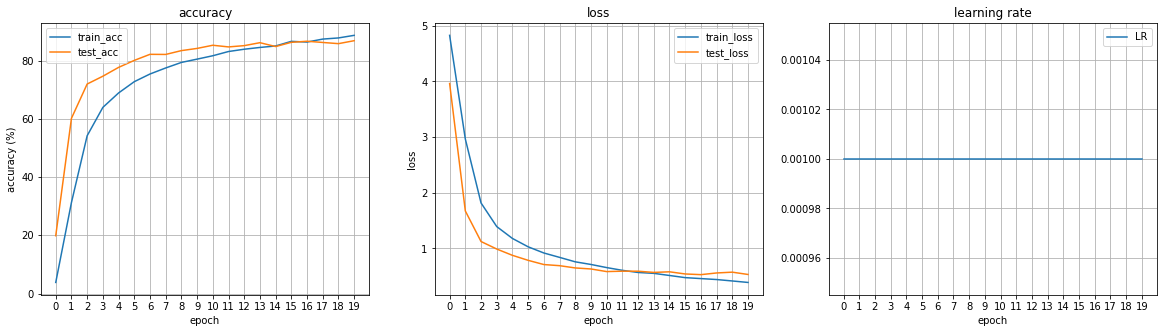

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


# Make Loss/Accuracy/Learning Rate plots
fig = plt.figure(figsize = (20, 5))

# accuracy plot
plt.subplot(131)
plt.plot(epochs, train_accs, label = 'train_acc')
plt.plot(epochs, test_accs, label = 'test_acc')
plt.legend()
plt.grid()
plt.xticks(np.arange(min(epochs), max(epochs)+1, 1.0))
plt.xlabel('epoch')
plt.ylabel('accuracy (%)')
plt.title('accuracy')

# loss plot
plt.subplot(132)
plt.plot(epochs, train_losses, label = 'train_loss')
plt.plot(epochs, test_losses, label = 'test_loss')
plt.legend()
plt.grid()
plt.xticks(np.arange(min(epochs), max(epochs)+1, 1.0))
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('loss')

# learning rate plot
plt.subplot(133)
plt.plot(epochs, learning_rates, label = 'LR')
plt.legend()
plt.grid()
plt.xticks(np.arange(min(epochs), max(epochs)+1, 1.0))
plt.xlabel('epoch')
plt.title('learning rate')

plt.show

In [ ]:
# SAVING MODEL
from pathlib import Path
import torch

# create model directory
MODEL_PATH = Path('drive/MyDrive/models')
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# create model save path
MODEL_NAME = "best_kanto_net.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# save the model state dict
print(f'Saving model to: {MODEL_SAVE_PATH}')
torch.save(obj=kanto_model.state_dict(), f=MODEL_SAVE_PATH)

Saving model to: drive/MyDrive/models/best_kanto_net.pth


In [ ]:
# LOADING MODEL
from pathlib import Path
import torch
from torchvision.models import vgg16, VGG16_Weights
from torch import nn

MODEL_PATH = Path('drive/MyDrive/models')
MODEL_SAVE_PATH = Path('drive/MyDrive/models')
MODEL_NAME = "best_kanto_net.pth" # change this to load different models
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# device config
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# load pretrained vgg16 for transfer learning
loaded_model = vgg16(weights=VGG16_Weights.DEFAULT).to(device)

# Get the number of input features for the last layer
num_ftrs = loaded_model.classifier[-1].in_features

# Modify the last layer to have len(pokemon_labels) [149] output features
loaded_model.classifier[-1] = nn.Linear(num_ftrs, len(pokemon_labels)).to(device)

# load dict to model
loaded_model.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

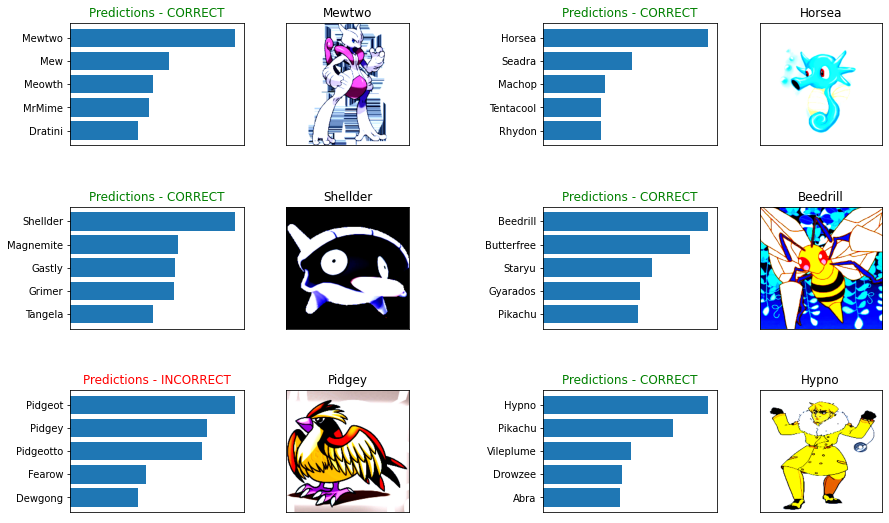

In [ ]:
# RANDOM TEST PLOT

import random
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Choose 6 random images
num_images = len(test_data)
rand_idx = random.sample(range(num_images), 6)

fig = plt.figure(figsize=(15, 9))
outer = gridspec.GridSpec(3, 2, wspace=0.3, hspace=0.5) # 3x2 grid

for i in range(6):
    image, label = test_data[rand_idx[i]]
    image = image.unsqueeze(0)  # Add batch dimension

    loaded_model.eval()
    with torch.no_grad():
        output = loaded_model(image.to(device))
        _, predicted = torch.topk(output, 5, dim=1) # top 5 predictions

    # get top 5 names/score results for plot
    names = []
    scores = []
    for k in range(5):
        names.append(test_data.classes[predicted[0][k]])
        scores.append(output[0][predicted[0][k]].cpu())

    # reverse order
    scores, names = zip(*sorted(zip(scores, names), reverse=False))

    # create subplot with image and bar graph
    inner = gridspec.GridSpecFromSubplotSpec(1, 2,
                    subplot_spec=outer[i], wspace=0.1, hspace=0.1)

    # plot image on right
    ax = plt.Subplot(fig, inner[1])
    image = image.squeeze(0).numpy().transpose(1, 2, 0)
    ax.imshow(image)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.set_title(f"{test_data.classes[label]}")

    # plot bar graph on left
    ax1 = plt.Subplot(fig, inner[0])
    ax1.barh(names, scores)
    is_correct = 'CORRECT' if label == predicted[0][0] else 'INCORRECT'
    title_color = 'green' if label == predicted[0][0] else 'red'
    ax1.set_title(f"Predictions - {is_correct}", color=title_color)
    ax1.axes.get_xaxis().set_visible(False)

    # add subplots to figure
    fig.add_subplot(ax)
    fig.add_subplot(ax1)

plt.show()